In [1]:
# default_exp mrna_content_regression

# mRNA content regression

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [141]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from importlib import reload
from joblib import load, dump
from sklearn.model_selection import PredefinedSplit
from sklearn import metrics

numpy.random.seed(42)

In [155]:
# export

import time
import fcsparser
import sklearn.linear_model
import sklearn.model_selection
from calibration_singlecell import classification
from functools import partial
import scipy.stats

In [5]:
meta, df = fcsparser.parse("D:/Experiment_data/weizmann/EhV/201/aggregates/non_intensity_T0234567_R123.fcs")
df_meta = df[["label", "replicate", "timepoint"]].astype(int)
df_meta["timepoint"] = df_meta["timepoint"].map(lambda a: meta["timepoint"].split(",")[a])
df_meta["replicate"] = df_meta["replicate"].map(lambda a: meta["replicate"].split(",")[a])
df = df.drop(columns=["label", "replicate", "timepoint"])

# mRNA content targets

In [6]:
_, fluor_df = fcsparser.parse("D:/Experiment_data/weizmann/EhV/201/aggregates/fluor_T0234567_R123.fcs")

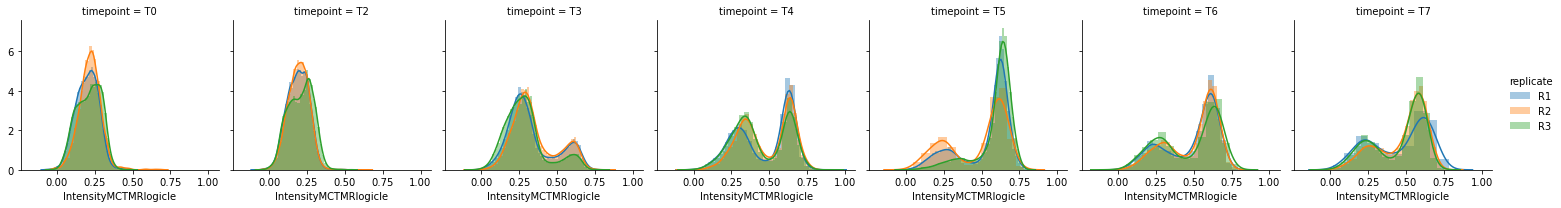

In [7]:
grid = seaborn.FacetGrid(col="timepoint", hue="replicate", data=pandas.concat([fluor_df, df_meta], axis=1))
grid.map(seaborn.distplot, "IntensityMCTMRlogicle")
grid.add_legend()

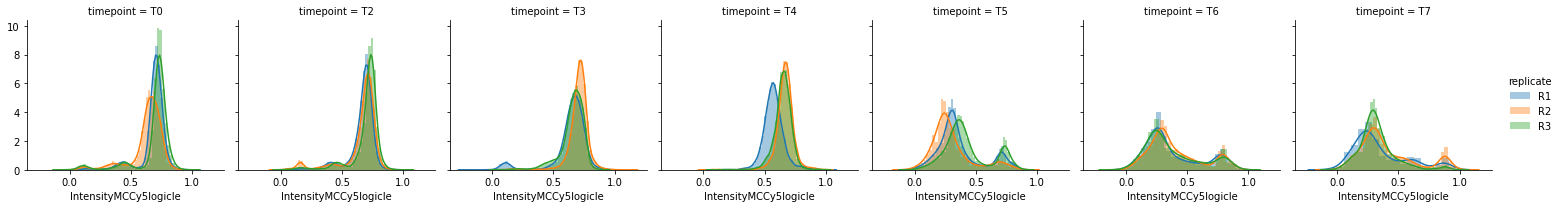

In [8]:
grid = seaborn.FacetGrid(col="timepoint", hue="replicate", data=pandas.concat([fluor_df, df_meta], axis=1))
grid.map(seaborn.distplot, "IntensityMCCy5logicle")
grid.add_legend()

# BF regression on targets

In [9]:
bf_df = df.filter(regex="(i?).*BF.*")

# Prepare folds

In [93]:
Xy_train = []
Xy_nested_train = []
Xy_test = []

target_col = "IntensityMCTMRlogicle"

test_fold, nested_test_folds = load("D:/Experiment_data/weizmann/EhV/201/5x3_samplesplit.dat")

for i, (train_idx, test_idx) in enumerate(PredefinedSplit(test_fold).split()):
    
    X = bf_df.iloc[train_idx]
    mean, std = X.mean(), X.std()
    
    y_mean = fluor_df[target_col].iloc[train_idx].mean()
    
    Xy_train.append(((X - mean) / std, fluor_df[target_col].iloc[train_idx] - y_mean))
    Xy_test.append(((bf_df.iloc[test_idx] - mean) / std, fluor_df[target_col].iloc[test_idx] - y_mean))
    
    Xy_train_tmp = []
    for nested_train_idx, nested_val_idx in PredefinedSplit(nested_test_folds[i]).split():
        
        X_train = bf_df.iloc[train_idx[nested_train_idx]]
        mean, std = X.mean(), X.std()
        
        X_val = bf_df.iloc[train_idx[nested_val_idx]]
        
        y_mean = fluor_df[target_col].iloc[train_idx[nested_train_idx]].mean()
        
        Xy_train_tmp.append((
            ((X_train - mean) / std, fluor_df[target_col].iloc[train_idx[nested_train_idx]] - y_mean),
            ((X_val - mean) / std, fluor_df[target_col].iloc[train_idx[nested_val_idx]] - y_mean)
        ))
        
    Xy_nested_train.append(Xy_train_tmp)

# Linear regression

## Lasso

In [159]:
models = []
Xy = []
for i, (train_idx, test_idx) in enumerate(PredefinedSplit(test_fold).split()):
    models.append(
        sklearn.linear_model.LassoCV(fit_intercept = False, normalize=True, n_jobs=3, cv = PredefinedSplit(nested_test_folds[i]))
    )

paths_lasso = classification.cv(models, Xy_train, "tmp", f"lasso_cv_{int(time.time())}", partial(classification.fit_func, dump_clf=True))

In [162]:
model = load(paths_lasso[0])

In [163]:
model.alpha_

7.027150557901087e-05

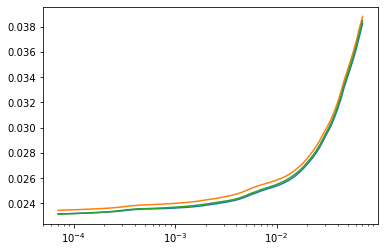

In [164]:
plt.plot(model.alphas_, model.mse_path_)
plt.xscale("log")

In [165]:
regr = model.predict(Xy_test[0][0])

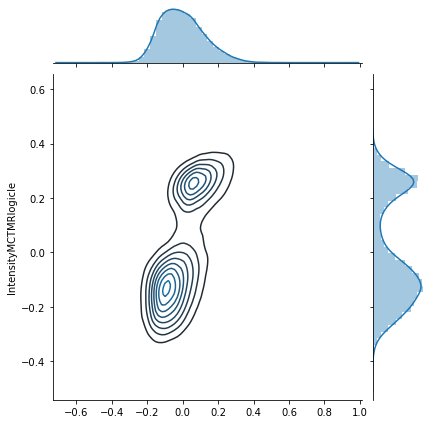

In [166]:
grid = seaborn.JointGrid(regr, Xy_test[0][1])
grid.plot_joint(seaborn.kdeplot)
grid.plot_marginals(seaborn.distplot)

## Ridge

In [174]:
models = []
Xy = []
for i, (train_idx, test_idx) in enumerate(PredefinedSplit(test_fold).split()):
    models.append(
        sklearn.linear_model.RidgeCV(fit_intercept = False, normalize=True, cv = PredefinedSplit(nested_test_folds[i]))
    )

paths_ridge = classification.cv(models, Xy_train, "tmp", f"lasso_cv_{int(time.time())}", partial(classification.fit_func, dump_clf=True))

In [175]:
model = load(paths_ridge[0])

In [176]:
model.alpha_

0.1

In [177]:
regr = model.predict(Xy_test[0][0])

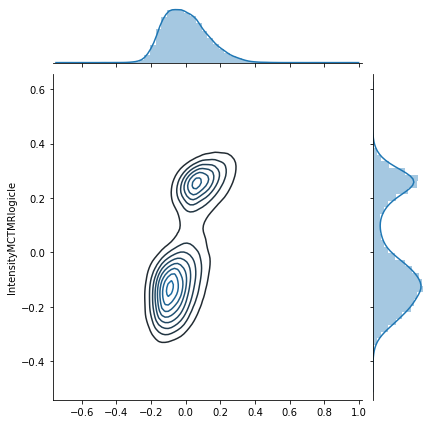

In [178]:
grid = seaborn.JointGrid(regr, Xy_test[0][1])
grid.plot_joint(seaborn.kdeplot)
grid.plot_marginals(seaborn.distplot)

## Lars

In [103]:
models = []
Xy = []
for i, (train_idx, test_idx) in enumerate(PredefinedSplit(test_fold).split()):
    models.append(
        sklearn.linear_model.LarsCV(fit_intercept = False, normalize=True, n_jobs=3, cv = PredefinedSplit(nested_test_folds[i]))
    )

classification.cv(models, Xy_train, "tmp", f"lars_cv_{int(time.time())}", partial(classification.fit_func, dump_clf=True))

['tmp\\lars_cv_1597674249_fold0.dat',
 'tmp\\lars_cv_1597674249_fold1.dat',
 'tmp\\lars_cv_1597674249_fold2.dat',
 'tmp\\lars_cv_1597674249_fold3.dat',
 'tmp\\lars_cv_1597674249_fold4.dat']

In [104]:
model = load('tmp/lars_cv_1597674249_fold0.dat')

In [105]:
model.alpha_

2.0086684216814778e-05

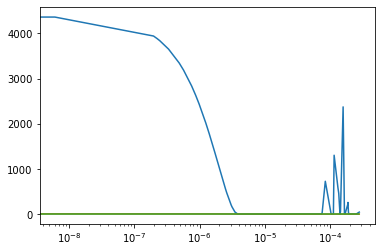

In [106]:
plt.plot(model.cv_alphas_, model.mse_path_)
plt.xscale("log")

In [107]:
regr = model.predict(Xy_test[0][0])

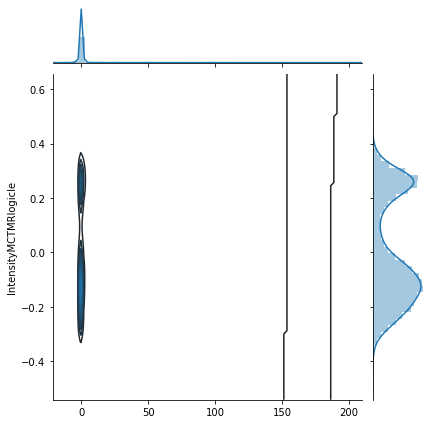

In [108]:
grid = seaborn.JointGrid(regr, Xy_test[0][1])
grid.plot_joint(seaborn.kdeplot)
grid.plot_marginals(seaborn.distplot)

<BarContainer object of 63 artists>

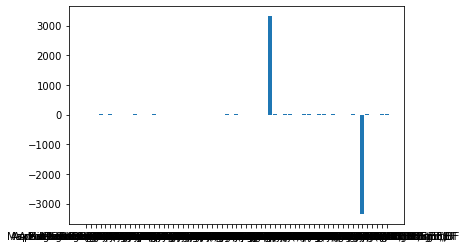

In [88]:
plt.bar(bf_df.columns, model.coef_)

# Non-linear

## XGB

In [131]:
from xgboost import XGBRegressor

In [132]:
model = XGBRegressor(n_estimators = 100, tree_method="gpu_hist")

In [133]:
paths_xgb = classification.cv(model, Xy_train, "tmp", f"xgb_50est_{int(time.time())}", partial(classification.fit_func, dump_clf=True))

In [183]:
models = [load(p) for p in paths_xgb]

In [184]:
regr = models[0].predict(Xy_test[0][0])

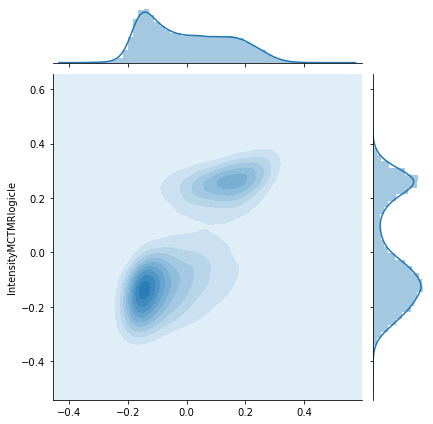

In [185]:
grid = seaborn.JointGrid(regr, Xy_test[0][1])
grid.plot_joint(seaborn.kdeplot, shade=True)
grid.plot_marginals(seaborn.distplot)

Text(0.5, 0, 'TMR Intensity (logicle, mean centered)')

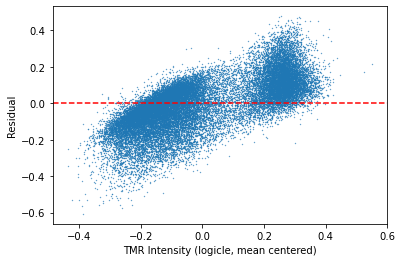

In [196]:
plt.scatter(Xy_test[0][1], Xy_test[0][1] - regr, s=0.1)
plt.axhline(0, linestyle="--", color="red")
plt.ylabel("Residual")
plt.xlabel("TMR Intensity (logicle, mean centered)")

# Model comparison

In [3]:
# export

metric_funcs = [
    metrics.explained_variance_score,
    metrics.max_error,
    metrics.mean_absolute_error,
    metrics.mean_squared_error,
    metrics.mean_squared_error,
    metrics.median_absolute_error,
    metrics.r2_score
]

def compute_metrics(paths, log):
    values = {f.__name__: [] for f in metric_funcs}
    for i, (path, Xy) in enumerate(zip(paths, Xy_test)):
        regr = load(path).predict(Xy[0])
        for f in metric_funcs:
            values[f.__name__].append(f(Xy[1], regr))

    if log:
        for k,v in values.items():
            print(f"{k}: {numpy.mean(v)} +- {scipy.stats.sem(v)}")
        print("----")
        
    return values

NameError: name 'metrics' is not defined